# Python Project - Crude Oil Price Prediction Model
___
* **Author:** Noah A. Velez
* **Date:** 2023-12-17

## Objective
In this notebook, I have developed a **Linear Regression Model** to predict the **Cushing, OK WTI Spot Price FOB**, leveraging data on the **US Crude Oil Supply**. This model serves as a demonstration of my Python knowedge, particularly in the field of data analysis and predictive modeling. The data utilized for this project is sourced from the **US Energy Information Administration**, specifically their **weekly reports on petroleum supply**, which can be found [here](https://www.eia.gov/petroleum/supply/weekly/)

# Exploritory Data Analysis
___

In [1]:
import pandas as pd
import plotly.express as px
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Read in Datasets
* Prices: [Spot Prices of Crude Oil, Motor Gasoline, and Heating Oil](https://www.eia.gov/dnav/pet/pet_pri_spt_s1_d.htm)
* Features: [Stocks of Crude Oil by PAD District, and Stocks of Petroleum Products, U.S. Totals](https://www.eia.gov/dnav/pet/pet_stoc_wstk_dcu_nus_w.htm)

In [2]:
supply  = pd.read_csv(r"Data/petroleum_supply_2023-12-08.csv")
stocks  = pd.read_csv(r"Data/petroleum_stocks_2023-12-08.csv")
crude_oil_prices = pd.read_csv(r"Data/crude_oil_prices_2023-12-11.csv")

## Clean and Review Datasets

In [3]:
crude_oil_prices.Date = pd.to_datetime(crude_oil_prices.Date)
stocks.Date = pd.to_datetime(stocks.Date)
supply.Date = pd.to_datetime(supply.Date)

groups = ['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)','Europe Brent Spot Price FOB (Dollars per Barrel)']
crude_oil_prices_long = crude_oil_prices.melt(id_vars='Date', value_vars=groups, var_name='Type', value_name='Price')

# Filtering crude oil prices for 'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'
crude_oil_prices_wti = crude_oil_prices_long[crude_oil_prices_long['Type']=='Cushing, OK WTI Spot Price FOB (Dollars per Barrel)']

# Merging datasets with pd.merge_asof() to align by nearest dates
price_supply = pd.merge_asof(crude_oil_prices_wti.sort_values('Date'), supply.sort_values('Date'), on='Date', direction='nearest')
price_supply_stocks = pd.merge_asof(price_supply.sort_values('Date'), stocks.sort_values('Date'), on='Date', direction='nearest').reset_index(drop=True)

# Filtering out rows where 'Price' is null
price_supply_stocks = price_supply[~price_supply['Price'].isnull()].copy()

# Creating a list of columns that contain 'Crude' or 'Date'
cols = [col for col in price_supply_stocks.columns if 'Crude' or 'Date' in col]
price_supply_stocks_filtered = price_supply_stocks[cols].drop(columns='Weekly U.S. Crude Oil Imports for SPR by Others  (Thousand Barrels per Day)',axis=1)

price_supply_stocks_filtered['Year'] = price_supply_stocks_filtered['Date'].dt.year
price_supply_stocks_filtered['Month'] = price_supply_stocks_filtered['Date'].dt.month
price_supply_stocks_filtered['Day'] = price_supply_stocks_filtered['Date'].dt.day
price_supply_stocks_filtered['Weekday'] = price_supply_stocks_filtered['Date'].dt.weekday
price_supply_stocks_filtered.fillna(method='bfill', inplace=True)

# price_supply_stocks_filtered.columns
# price_supply_stocks_filtered.info()
# price_supply_stocks_filtered.nunique()
# price_supply_stocks_filtered.describe()
# price_supply_stocks_filtered.head()

## Plot Crude Oil Price Overtime

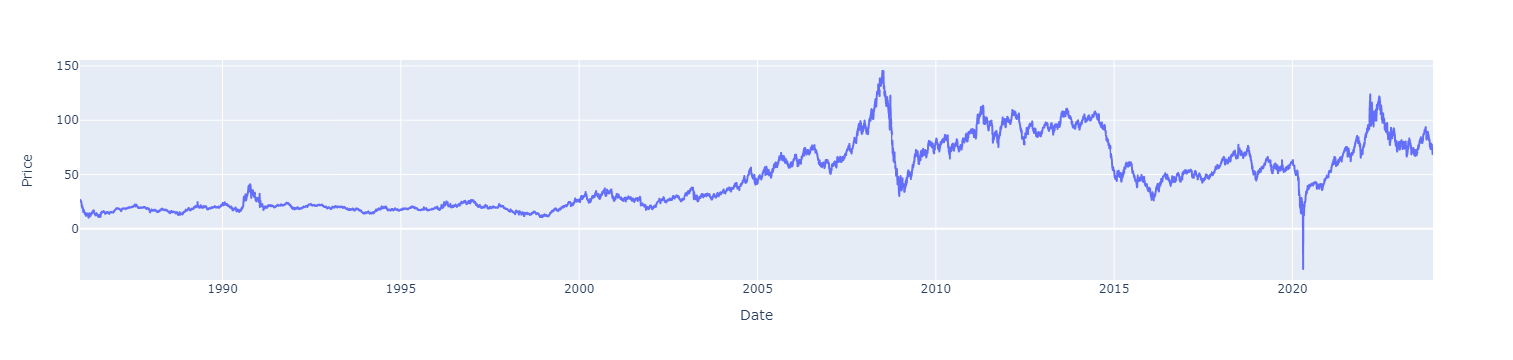

In [13]:
label_dict = {'Date': 'Date', 'Type': 'Oil Type', 'Price': 'Price (Dollars per Barrel)'}
fig = px.line(price_supply_stocks_filtered, x= 'Date', y= 'Price', labels='Cushing, OK WTI Spot Price FOB (Dollars per Barrel)')
fig.show()

# US Crude Oil Price Prediction Model (LRM)
___
The code below seperates the data between `training` and `testing` datasets the the development of `Linear Regression` model

In [5]:
df = price_supply_stocks_filtered

X = df.drop(['Price', 'Date', 'Type'], axis=1)  # Features
y = df['Price']                                 # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## Scatter Plot of Actual vs. Predicted Prices
* This plot helps in assessing how well the model's predictions match the actual values.
* Based off this plot the model tends to overestimate from 30 to 80 from which it increasingly underestimates

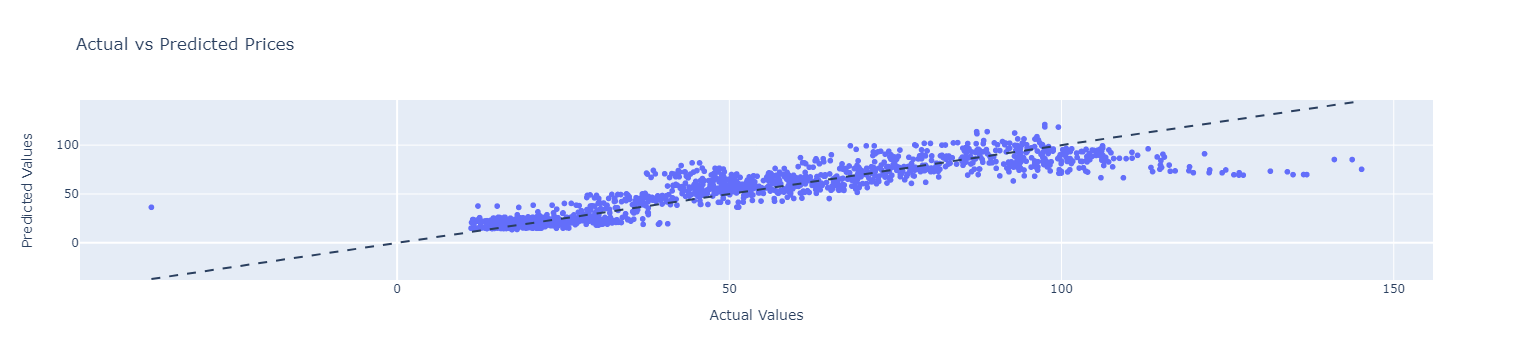

In [6]:
fig = px.scatter(x=y_test, y=y_pred, labels={'x': 'Actual Values', 'y': 'Predicted Values'}, title='Actual vs Predicted Prices')
fig.add_shape(type='line', line=dict(dash='dash'), x0=y_test.min(), y0=y_test.min(), x1=y_test.max(), y1=y_test.max())
fig.show()

## Scatter Plot of Residuals vs. Predicted Prices
* Residuals are the differences between the actual values and the predicted values. This plot helps in understanding the **variance of the prediction errors**
* Based on the chart below the model appears to be fairly `homoscedastic`

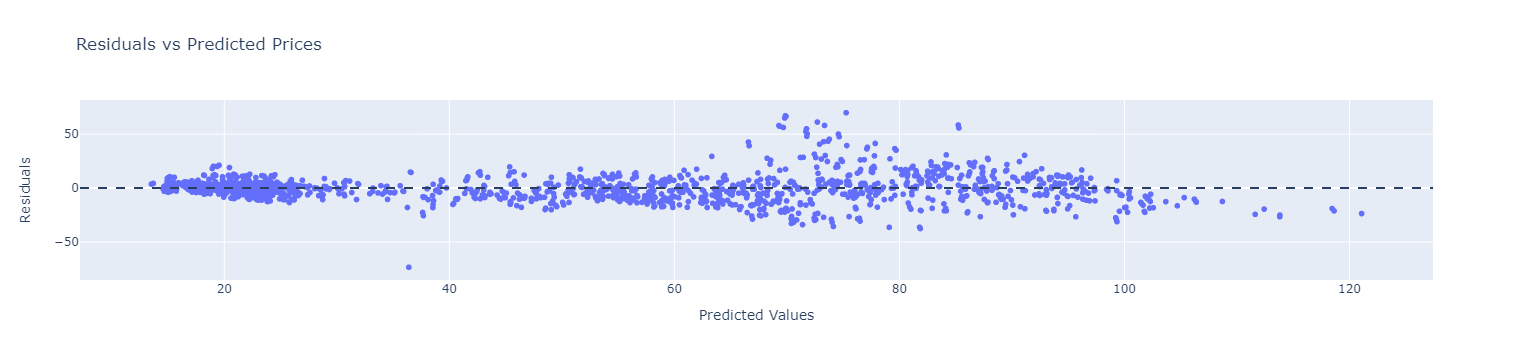

In [7]:
residuals = y_test - y_pred
fig = px.scatter(x=y_pred, y=residuals, labels={'x': 'Predicted Values', 'y': 'Residuals'}, title='Residuals vs Predicted Prices')
fig.add_hline(y=0, line_dash="dash")
fig.show()

## Resulting Coefficients
Review the coefficients of the model to understand the influence of each feature. Each coefficient represents the change in the target variable for a one-unit change in the corresponding feature, assuming all other features remain constant.

In [8]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient']).sort_values('Coefficient')
coefficients

,Coefficient
Weekly U.S. Crude Oil SPR Stock Change (Thousand Barrels per Day),-2.824781
Weekly U.S. Crude Oil Stock Change Excluding SPR (Thousand Barrels per Day),-2.798622
Weekly U.S. Oxygenate Plant Production of Fuel Ethanol (Thousand Barrels per Day),-2.032203
Weekly U.S. Refiner and Blender Net Production of Renewable Fuel-Oxygenates Excluding Fuel Ethanol (Thousand Barrels per Day),-1.819134
Weekly U.S. Transfers to Crude Oil Supply of Condensate Production and Alaskan NGL (Thousand Barrels per Day),-0.871420
Weekly U.S. Transfers to Crude Oil Supply of Crude Oil (Thousand Barrels per Day),-0.169470
Weekly U.S. Supply Adjustment of Total Petroleum (Excluding Crude Oil) (Thousand Barrels per Day),-0.156153
Weekly Alaska Field Production of Crude Oil (Thousand Barrels per Day),-0.067870
Weekday,-0.042574
Weekly Lower 48 States Field Production of Crude Oil (Thousand Barrels per Day),-0.018669


## Model Accuracy (MAE, MSE, RMSE, R-squared)
For all the variation in the Price data the model fits well with an R-squared of 0.85
* **Mean Absolute Error (MAE) - 7.43:** 7.43/46.82 = 15.87% error
* **Mean Squared Error (MSE) - 133.28 & Root Mean Squared Error (RMSE) - 11.43:**  11.43/46.82 = 24.41%
* **R-squared - 0.85:** An R-squared of 0.85 suggests that 85% of the variance in your target variable can be explained by the model

In [9]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

price_supply_stocks.Price.describe()

Mean Absolute Error (MAE): 7.4281855267375825
Mean Squared Error (MSE): 130.7329453111313
Root Mean Squared Error (RMSE): 11.433850852233961
R-squared: 0.8515747966891103


count    9558.000000
mean       46.817994
std        29.657472
min       -36.980000
25%        20.080000
50%        37.635000
75%        69.617500
max       145.310000
Name: Price, dtype: float64